[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fadheladlansyah/<repo>/blob/master/<filename>.ipynb)

# 0. Set access to kaggle and download dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# !pip install -q kaggle

# upload kaggle API key file
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# download dataset, unzip, delete zip
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification
!unzip -q fruits-fresh-and-rotten-for-classification.zip
!rm fruits-fresh-and-rotten-for-classification.zip

100% 3.58G/3.58G [00:43<00:00, 21.8MB/s]
100% 3.58G/3.58G [00:43<00:00, 87.6MB/s]


# 1. Libraries and config

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from datetime import datetime
import zipfile
import random
import json
import shutil
import os
import gc
import warnings
warnings.filterwarnings("ignore")

import cv2
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

In [ ]:
SEED = 11
np.random.seed(seed=SEED)

# 2. The Data

- The images are already augmented from (kind of) original image
- Augmentation include of rotating, zooming, shifting, c/w the drawbacks such cropped image happen
- It is not a rich image collection. Typically a single fruit in a single color background. Also the fruits are not from various family.
- Various of size of image

In [ ]:
dataset_dir = '/content/dataset/dataset'
classes = os.listdir(os.path.join(dataset_dir,'train'))

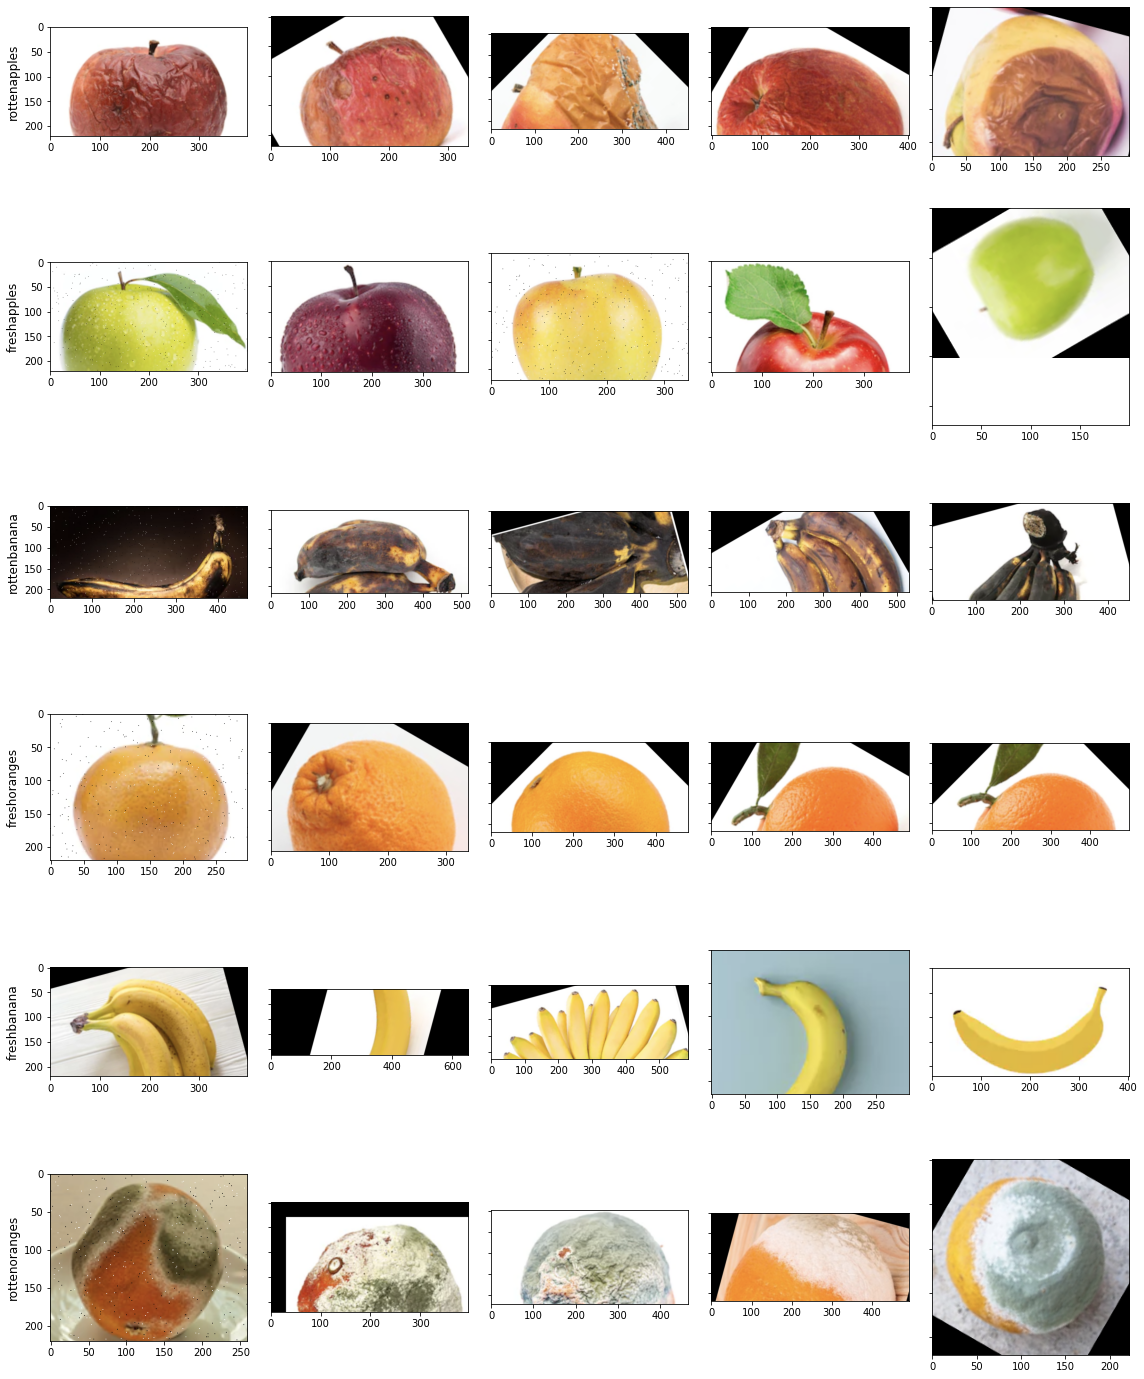

In [ ]:
nfiles_per_class = 5
selected_files = []
selected_files_path = []


for root, dirs, files in os.walk(os.path.join(dataset_dir, 'train')):
  nfiles = len(files)
  if len(dirs)==0 and nfiles>0:
    random_ = np.random.randint(0,nfiles)-nfiles_per_class
    selected_files.append(files[random_:random_+3])
    selected_files_path.append([os.path.join(root,f) for f in files[random_:random_+nfiles_per_class]])
    # display(root, selected_files)


nrows, ncols  = len(classes), nfiles_per_class
fig, axes = plt.subplots(nrows, ncols, figsize=(nfiles_per_class*3.2,20), sharey=True)

for i, ax in enumerate(axes.flatten()):
    selected_files_path_flatten = [path for subpath in selected_files_path for path in subpath]

    # read image
    img = cv2.imread(selected_files_path_flatten[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # show
    if i in range(0,nrows*ncols,ncols):
        ax.set_ylabel(f"{classes[int(i/ncols)]}", rotation=90, fontsize=12)
    # ax.axis("off")
    ax.imshow(img)

plt.tight_layout()
plt.show()

# 3. Model

### Simple tes model to tfjs

In [ ]:
HEIGHT,WIDTH = 60,60
BATCH_SIZE = 50
EPOCHS = 10

train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'test')



# model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(HEIGHT,WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-3),
              metrics=['acc'],
              )

# model.summary()

# data generator
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(HEIGHT,WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        )

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(HEIGHT,WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        )

history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        verbose=1,
        )

In [ ]:
model_name = "model_fruit"
saved_model_path = f"/content/{model_name}.h5"
model.save(saved_model_path)

# # !pip install tensorflowjs
!tensorflowjs_converter \
  --input_format=keras \
  --output_format=tfjs_layers_model \
  ./model_fruit.h5 \
  ./

with zipfile.ZipFile(f"/content/{model_name}.zip", "w") as zf:
  zf.write("model.json")
  for f in os.listdir(os.getcwd()):
    if f[-4:] == ".bin":
      zf.write(f)

### Transfer learning - InceptionV3

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3


HEIGHT,WIDTH = 150,150
BATCH_SIZE = 50
EPOCHS = 5

train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'test')



# pre-trained InceptionV3 model
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed5')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(6, activation='softmax')(x)           
model = Model(pre_trained_model.input, x)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-3),
              metrics=['acc'])


# data generator
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(HEIGHT,WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        )

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(HEIGHT,WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        )

history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        verbose=1,
        )

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
model_name = "model_fruit_inception"
saved_model_path = f"/content/{model_name}.h5"
model.save(saved_model_path)

!pip install tensorflowjs
!tensorflowjs_converter \
  --input_format=keras \
  --output_format=tfjs_layers_model \
  ./model_fruit_inception.h5 \
  ./

with zipfile.ZipFile(f"/content/{model_name}.zip", "w") as zf:
  zf.write("model.json")
  for f in os.listdir(os.getcwd()):
    if f[-4:] == ".bin":
      zf.write(f)
      os.remove(f)

### ~170mb

### Transfer learning - EfficientNet

In [ ]:
# !pip install efficientnet

# import efficientnet.keras as efn 

In [ ]:
# pre_trained_model2 = efn.EfficientNetB3(input_shape = (150, 150, 3), include_top=False, weights="imagenet")
pre_trained_model2 = tf.keras.applications.EfficientNetB7(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=(150, 150, 3),
    pooling=None, classes=1000, classifier_activation='softmax', **kwargs
)


## 1) Freezing Feature Extractor Layer
# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model2.layers:
    layer.trainable = False

pre_trained_model2.summary()

In [ ]:
## 2) Get Last Layer shape
last_layer = pre_trained_model2.get_layer('top_activation')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

In [ ]:
# from keras import models
# from keras import layers

model = Sequential()
model.add(pre_trained_model2)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='sigmoid'))


model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

### Transfer learning - NasNET

In [ ]:
# Download weight of NASNETMobile 
!wget https://storage.googleapis.com/tensorflow/keras-applications/nasnet/NASNet-mobile-no-top.h5

--2020-06-19 19:36:32--  https://storage.googleapis.com/tensorflow/keras-applications/nasnet/NASNet-mobile-no-top.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 2607:f8b0:4001:c10::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19993432 (19M) [application/octet-stream]
Saving to: ‘NASNet-mobile-no-top.h5’

NASNet-mobile-no-to 100%[===================>]  19.07M  46.2MB/s    in 0.4s    

2020-06-19 19:36:33 (46.2 MB/s) - ‘NASNet-mobile-no-top.h5’ saved [19993432/19993432]



In [ ]:
input_shape = (150, 150, 3)
pre_trained_model = tf.keras.applications.NASNetMobile(weights = None, include_top=False, input_shape = input_shape)
pre_trained_model.load_weights('NASNet-mobile-no-top.h5')
for layer in pre_trained_model.layers:
    layer.trainable = False
pre_trained_model.summary()

In [ ]:
## Determine Last layer
last_layer = pre_trained_model.get_layer('activation_187')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 1056)


In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)                  
x = layers.Dense  (6, activation='softmax')(x)         

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 74, 74, 32)   128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           stem_bn1[0][0]                   
______________________________________________________________________________________________

In [ ]:
HEIGHT,WIDTH = 150,150
BATCH_SIZE = 50
EPOCHS = 5

train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'test')

# data generator
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(HEIGHT,WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        )

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(HEIGHT,WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        )

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [ ]:
## Tensorboard
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = [tensorboard_callback, myCallback()]

history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        verbose=1,
        callbacks=callbacks,
        )

Epoch 1/5
219/219 [==============================] - 662s 3s/step - loss: 0.4141 - accuracy: 0.8848 - val_loss: 0.1349 - val_accuracy: 0.9459
Epoch 2/5
219/219 [==============================] - 653s 3s/step - loss: 0.1157 - accuracy: 0.9600 - val_loss: 0.1057 - val_accuracy: 0.9659
Epoch 3/5
219/219 [==============================] - 654s 3s/step - loss: 0.0705 - accuracy: 0.9757 - val_loss: 0.1184 - val_accuracy: 0.9622
Epoch 4/5
219/219 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.9819
Reached 98% accuracy so cancelling training!
219/219 [==============================] - 653s 3s/step - loss: 0.0478 - accuracy: 0.9819 - val_loss: 0.1183 - val_accuracy: 0.9644


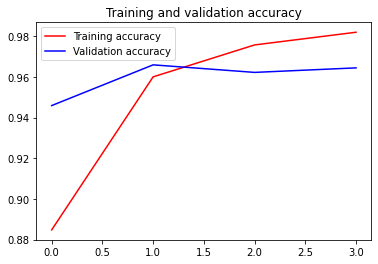

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
# copy log directory to drive

!gsutil cp -r /content/logs/20200619-194114/ /content/drive/My\ Drive/Classroom/JKT2-B\ Final\ Project/logs/

Copying file:///content/logs/20200619-194114/validation/events.out.tfevents.1592596352.c6a7280f36ac.645.51232.v2...
Copying file:///content/logs/20200619-194114/train/events.out.tfevents.1592595674.c6a7280f36ac.645.25663.v2...
Copying file:///content/logs/20200619-194114/train/events.out.tfevents.1592595694.c6a7280f36ac.profile-empty...
Copying file:///content/logs/20200619-194114/train/plugins/profile/2020_06_19_19_41_34/c6a7280f36ac.tensorflow_stats.pb...
/ [4 files][  8.9 MiB/  8.9 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file:///content/logs/20200619-194114/train/plugins/profile/2020_06_19_19_41_34/c6a7280f36ac.input_pipeline.pb...
Copying file:///content/logs/20200619-194114/train/plugins/profile/2020_06_19_19_41_

In [ ]:
# save model to keras saved model h5 (also in drive)
# convert keras saved model to json graph model
# tfjs still cant handle some layers such : separableConv2D

model_name = "model_fruit_nasnet"
saved_model_path = f"/content/{model_name}.h5"  
model.save(saved_model_path)
saved_model_path_drive = f"/content/drive/My Drive/Classroom/JKT2-B Final Project/{model_name}.h5"  
model.save(saved_model_path_drive)

!pip install tensorflowjs
!tensorflowjs_converter \
  --input_format=keras \
  --output_format=tfjs_graph_model \
  ./model_fruit_nasnet.h5 \
  ./

with zipfile.ZipFile(f"/content/{model_name}_graph.zip", "w") as zf:
  zf.write("model.json")
  for f in os.listdir(os.getcwd()):
    if f[-4:] == ".bin":
      zf.write(f)
      os.remove(f)

     |████████████████████████████████| 61kB 2.1MB/s 
     |████████████████████████████████| 92kB 5.1MB/s 
     |████████████████████████████████| 144.4MB 95kB/s 
     |████████████████████████████████| 256kB 43.7MB/s 
     |████████████████████████████████| 921kB 39.6MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=5d1b0be61ab705f62ca957c4b95c9270edb2662a09fa838720e6d4a0615b1ee1
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tensorflow-hub 0.8.0
    Uninstalling tensorflow-hub-0.8.0:
      Successfully uninstalled tensorflow-hub-0.8.0
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation:

In [ ]:
model_name = "model_fruit_nasnet"
saved_model_path_drive = f"/content/drive/My Drive/Classroom/JKT2-B Final Project/{model_name}.h5"

model = tf.keras.models.load_model(filepath=saved_model_path_drive, custom_objects=None, compile=True)
# model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 74, 74, 32)   128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           stem_bn1[0][0]                   
______________________________________________________________________________________________

# 4. Visualize

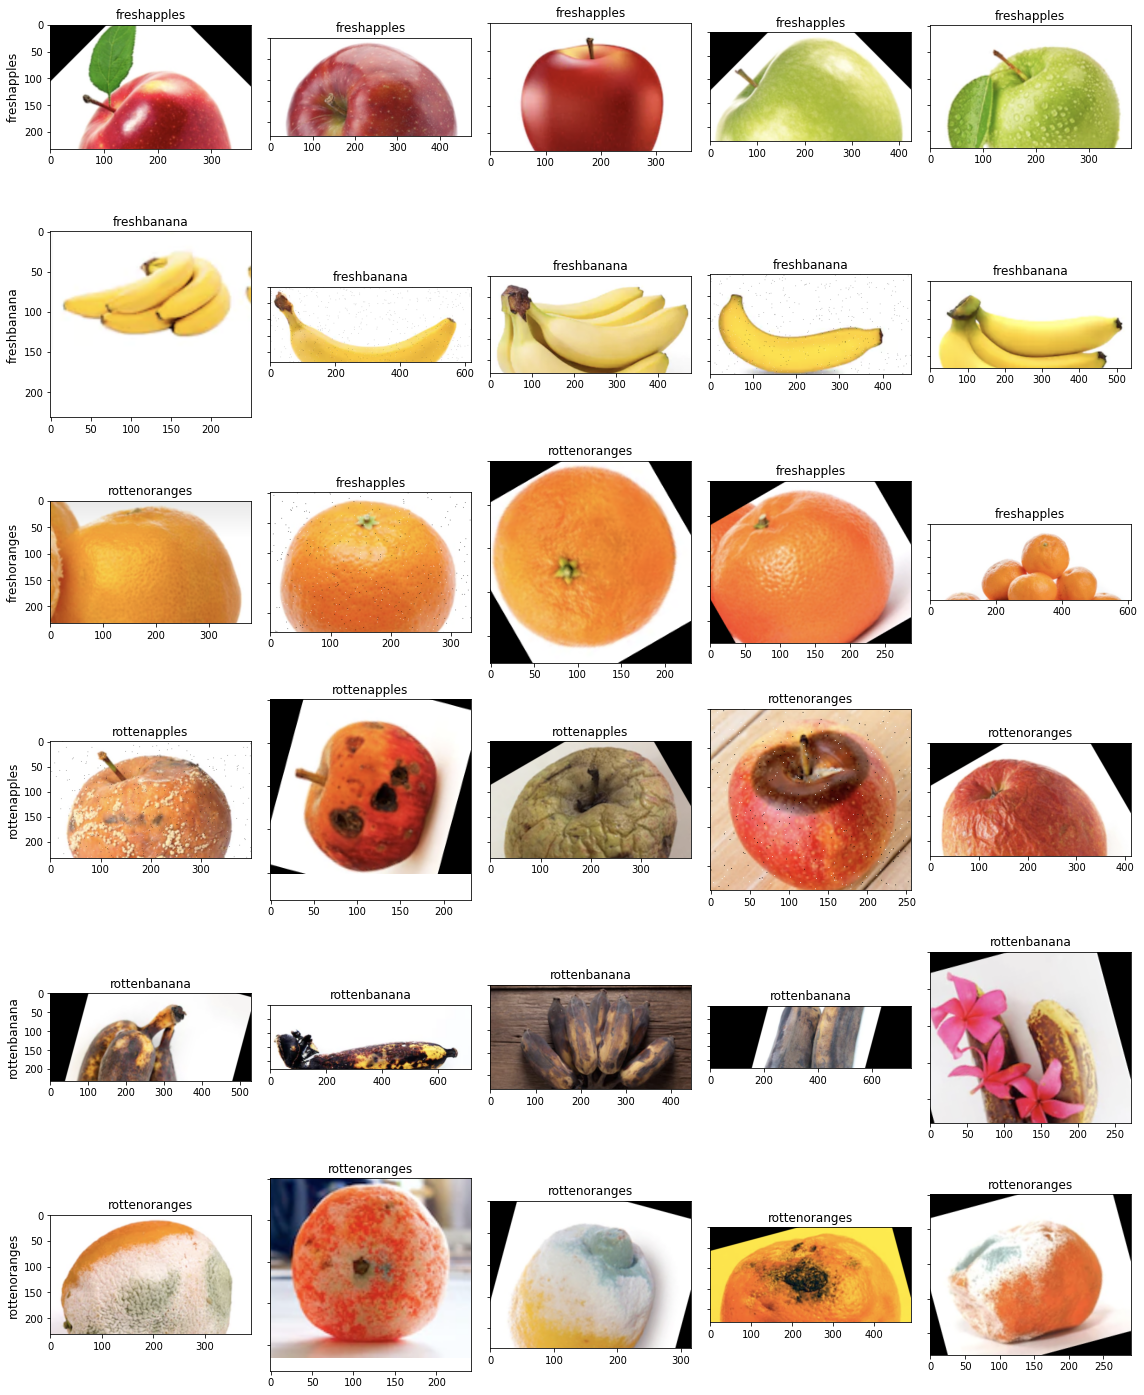

In [ ]:
test_dataset_dir = '/content/dataset/dataset/test'
classes = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']

nfiles_per_class = 5
selected_files = []
selected_files_path = []

for class_ in classes:
  dir_ = os.path.join(test_dataset_dir, class_)
  files = os.listdir(dir_)
  nfiles = len(files)

  random_ = np.random.randint(0,nfiles)-nfiles_per_class
  selected_files.append(files[random_:random_+3])
  selected_files_path.append([os.path.join(dir_,f) for f in files[random_:random_+nfiles_per_class]])
  # display(root, selected_files)


nrows, ncols  = len(classes), nfiles_per_class
fig, axes = plt.subplots(nrows, ncols, figsize=(nfiles_per_class*3.2,20), sharey=True)

selected_files_path_flatten = [path for subpath in selected_files_path for path in subpath]

for i, ax in enumerate(axes.flatten()):

    # read image
    img = cv2.imread(selected_files_path_flatten[i])
    img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_pred = Image.fromarray(img, 'RGB')
    img_pred = img_pred.resize((150, 150))
    img_pred = np.array(img_pred)
    img_pred = np.expand_dims(img_pred, axis=0)
    img_pred = img_pred/255.

    prediction = model.predict(img_pred)

    # show
    if i in range(0,nrows*ncols,ncols):
        ax.set_ylabel(f"{classes[int(i/ncols)]}", rotation=90, fontsize=12)
    # ax.axis("off")
    ax.imshow(img_show)
    ax.set_title(f"{classes[np.argmax(prediction)]}")

plt.tight_layout()
plt.show()

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/drive/My\ Drive/Classroom/JKT2-B\ Final\ Project/logs/